# Initial Data Profiling

**Week 1** - BayesRisk Project

**Author:** Desmond Momanyi Mariita
**Date:** 2026-01-11

---

In [2]:
# Standard imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
import sys
sys.path.insert(0, '../src')

# Display settings
pd.set_option('display.max_columns', 100)
%matplotlib inline

## 1. Objectives
To establish the "Ground Truth" of the dataset. We will:
- Load and inspect the raw structure.
- Define the Target Variable (Default vs. Non-Default) clearly.
- Identify Data Leakage (columns that must be banned).
- Audit Missing Data patterns.

## 2. Implementation

In [3]:

# --- STEP 1: DEFINE PATH (2 Levels Up) ---
file_path = '../../data/external/3/Loan_status_2007-2020Q3.gzip'

# SANITY CHECK: Verify the file exists before loading
if os.path.exists(file_path):
    print(f"✅ Success! Found the file at: {file_path}")
    print(f"   File size: {os.path.getsize(file_path) / (1024*1024):.2f} MB")
else:
    print(f"❌ Error: File NOT found at {file_path}")
    print(f"   Current folder is: {os.getcwd()}")
    # Stop execution if file isn't found
    raise FileNotFoundError(f"Check your path. Python is looking here: {os.path.abspath(file_path)}")

# --- STEP 2: LOAD & FILTER COLUMNS ---

print("Loading data... (This may take 1-2 minutes)")
df = pd.read_csv(file_path, low_memory=False)

display(df.head())

✅ Success! Found the file at: ../../data/external/3/Loan_status_2007-2020Q3.gzip
   File size: 1691.31 MB
Loading data... (This may take 1-2 minutes)


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,...,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,NaN,May-2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,NaN,Oct-2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-2014,649.91,NaN,Jun-2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,other,personel,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,35.0,NaN,10.0,0.0,5598.0,21%,37.0,f,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-2015,357.48,NaN,Apr-2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclu

##### Step 2: The Target Variable Analysis (Crucial)
We need to analyze the loan_status column to decide what counts as a "Bad Loan."
The Governance Logic:
- Closed Loans: We know the outcome (Paid or Defaulted). These are our training samples.

- Active Loans ("Current"): We don't know the outcome yet. If we treat them as "Good," we might be wrong (they could default tomorrow). If we treat them as "Bad," we are definitely wrong. Decision: Exclusion.

- The "Grey" Zone: Loans that are 16-30 days late. They are "dirty" but not yet "default." Including them blurs the signal. Decision: Exclusion.

Raw Loan Status Counts:
loan_status
Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
NaN                                                          1
Name: count, dtype: int64


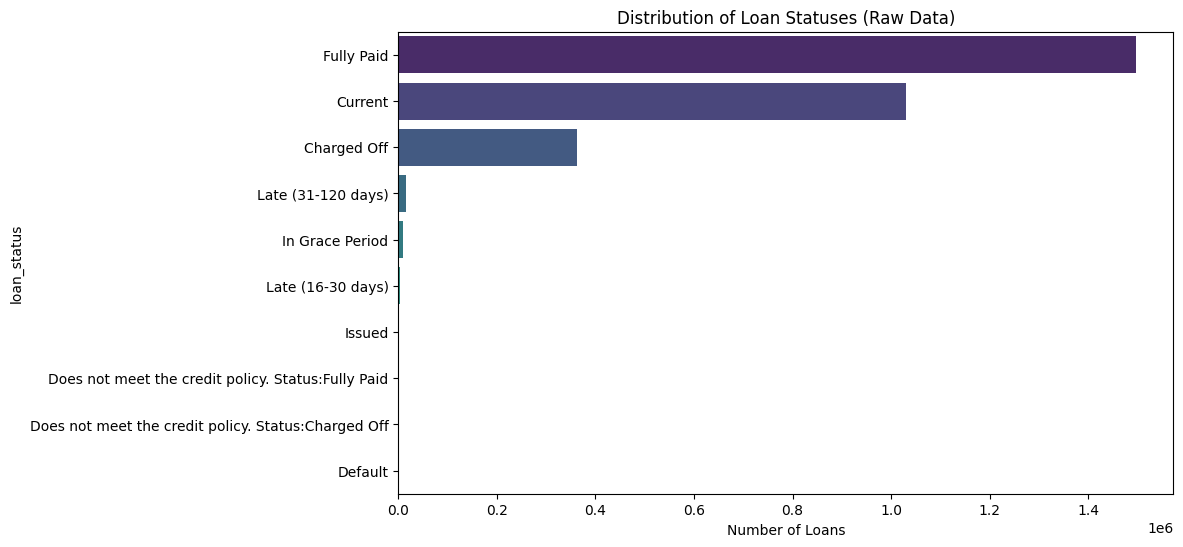

Total Rows: 2925493
Rows Kept (Closed Loans): 1877679 (64.2% of data)
Rows Dropped (Indeterminate): 1047814 (35.8% of data)


In [4]:
# 1. Inspect the Raw Counts
status_counts = df['loan_status'].value_counts(dropna=False)
print("Raw Loan Status Counts:")
print(status_counts)

# 2. Visualize the Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=status_counts.values, y=status_counts.index, hue=status_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Loan Statuses (Raw Data)')
plt.xlabel('Number of Loans')
plt.show()

# 3. Create the Binary Target & Filter
# Definition: 
# Good (0) = Fully Paid
# Bad (1) = Charged Off, Default, Late (31-120 days)
# Excluded = Current, In Grace Period, Late (16-30 days)

def define_target(status):
    if status == 'Fully Paid':
        return 0
    elif status in ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (31-120 days)']:
        return 1
    else:
        return -1 # Mark for drop

df['target'] = df['loan_status'].apply(define_target)

# 4. Report on Exclusions
kept = df[df['target'] != -1]
dropped = df[df['target'] == -1]

print(f"Total Rows: {len(df)}")
print(f"Rows Kept (Closed Loans): {len(kept)} ({len(kept)/len(df):.1%} of data)")
print(f"Rows Dropped (Indeterminate): {len(dropped)} ({len(dropped)/len(df):.1%} of data)")

# Update df to only keep the valid rows for modeling
df_modeling = kept.copy()

##### Step 3: The Leakage Audit ("Time Travel" Check)
Data leakage is the number 1 reason models fail audit. You must identify columns that contain information not available at the time of application.

The Governance Logic:

- We need to verify availability.

- Example: total_pymnt (Total Payment) is 0 when a user applies. If it is > 0, time has passed. We cannot use it.

In [6]:
# List of potential leakage keywords
leakage_keywords = [
    'pymnt', 'rec', 'out_prncp', 'recoveries', 
    'collection', 'last_', 'hardship', 'settlement', 'funding'
]

# Find columns containing these keywords
suspect_columns = [col for col in df_modeling.columns if any(kw in col for kw in leakage_keywords)]

print(f"Potential Leakage Columns found: {len(suspect_columns)}")
print(suspect_columns)

# VISUAL PROOF: Why we drop 'recoveries'
# If recoveries > 0, the Target is ALWAYS 1 (Bad). This is leakage.
if 'recoveries' in df_modeling.columns:
    print("\nCheck Leakage on 'recoveries':")
    print(df_modeling.groupby('target')['recoveries'].mean())
    # You will likely see 0.00 for target=0 and a high number for target=1

Potential Leakage Columns found: 43
['pymnt_plan', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'inq_last_12m', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'pub_rec_bankruptcies', 'sec_app_inq_last_6mths', 'sec_app_collections_12_mths_ex_med', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag']

Check Leakage on 'recove

##### Step 4: Missing Value Audit (Nullity Matrix)
Before we fix missing values, we must understand why they are missing.

- MCAR (Missing Completely at Random): Glitch. Safe to drop/impute.

- MNAR (Missing Not at Random): Missing means something. (e.g., mths_since_last_delinq is NaN because the person has never been delinquent). This is valuable info.

Top 10 Columns by Missing Percentage:


hardship_loan_status       99.283530
hardship_status            99.281720
hardship_type              99.281666
deferral_term              99.281666
hardship_length            99.281666
payment_plan_start_date    99.281666
hardship_start_date        99.281666
hardship_end_date          99.281666
hardship_dpd               99.281666
hardship_reason            99.281613
dtype: float64

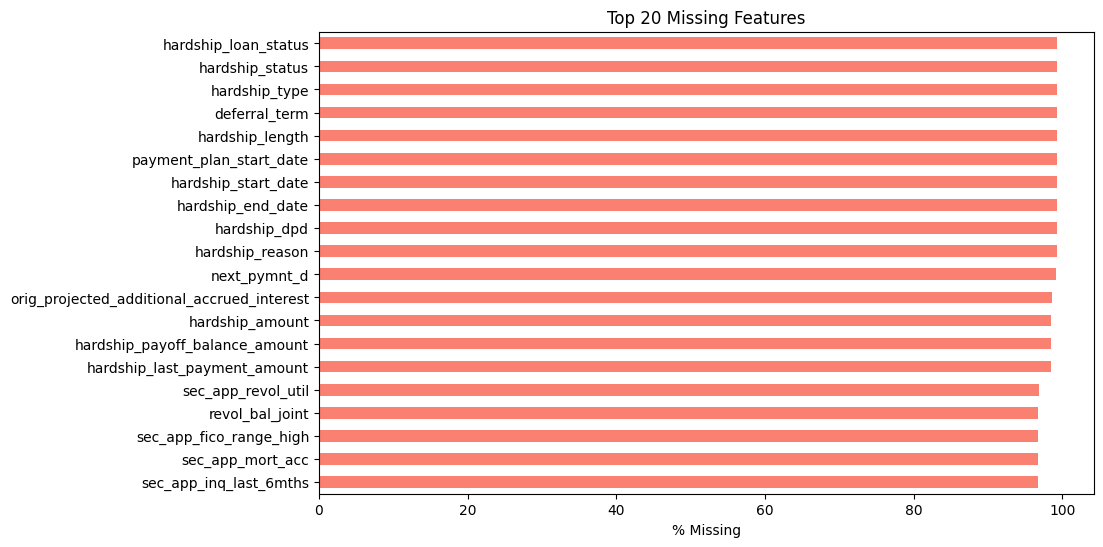

In [7]:
# Calculate missing percentage
missing = df_modeling.isnull().sum()
missing = missing[missing > 0]
missing_pct = (missing / len(df_modeling)) * 100
missing_pct = missing_pct.sort_values(ascending=False)

print("Top 10 Columns by Missing Percentage:")
display(missing_pct.head(10))

# Visualize
plt.figure(figsize=(10, 6))
missing_pct.head(20).plot(kind='barh', color='salmon')
plt.title('Top 20 Missing Features')
plt.xlabel('% Missing')
plt.gca().invert_yaxis() # Highest missing at top
plt.show()

## 4. Conclusions

In [8]:
# Save to 'interim' folder if you have one, or just 'data'

df_modeling.to_pickle('../../data/interim/loans_cleaned_base.pkl')
print("Base modeling data saved.")

Base modeling data saved.
